# HAB Capstone Data Wrangling 3 - Ohio EPA Data

In [1]:
import datetime as dt
import folium
import geopy.distance
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
import pandas as pd
import seaborn

import sys
sys.path.append('../src/')
from visualization.visualize import *

The Ohio EPA and GLENDA data was already cleaned in the first data wrangling notebook. Refer back to that notebook for cleaning of the raw data.

In [2]:
oh_df = pd.read_csv('../data/interim/oh_epa.csv', index_col=0, parse_dates = ['Collect Date'])
oh_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 885
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Site             886 non-null    object        
 1   Site ID          886 non-null    object        
 2   Site Type        886 non-null    object        
 3   Collect Date     886 non-null    datetime64[ns]
 4   Collection Time  886 non-null    object        
 5   Sample ID        886 non-null    object        
 6   Parameter        886 non-null    object        
 7   Result           886 non-null    float64       
 8   Units            886 non-null    object        
 9   Qual.*           193 non-null    object        
 10  Program          537 non-null    object        
 11  Lab              886 non-null    object        
 12  Lat              886 non-null    float64       
 13  Long             886 non-null    float64       
 14  Saturation       886 non-null    bool     

In [3]:
oh_df.head()

,Site,Site ID,Site Type,Collect Date,Collection Time,Sample ID,Parameter,Result,Units,Qual.*,Program,Lab,Lat,Long,Saturation
0,LAKE ERIE UTILITIES CO 2-TP-LT2001-Raw,6262096-LT2001,PWS Plant Intake Site,2018-12-25,00:00,2121629,Microcystins,0.0,ug/L,NaN,NaN,OSU STONE LABORATORY,41.689305,-82.817555,False
1,LAKE ERIE UTILITIES CO 2-TP-LT2001-Raw,6262096-LT2001,PWS Plant Intake Site,2018-12-10,00:00,2115433,Microcystins,0.0,ug/L,NaN,NaN,OSU STONE LABORATORY,41.689305,-82.817555,False
2,LAKE ERIE UTILITIES CO 2-TP-LT2001-Raw,6262096-LT2001,PWS Plant Intake Site,2018-11-26,00:00,2107254,Microcystins,0.0,ug/L,NaN,NaN,OSU STONE LABORATORY,41.689305,-82.817555,False
3,LAKE ERIE UTILITIES CO 2-TP-LT2001-Raw,6262096-LT2001,PWS Plant Intake Site,2018-11-12,00:00,2103289,Microcystins,0.0,ug/L,NaN,NaN,OSU STONE LABORATORY,41.689305,-82.817555,False
4,Lake Erie Utilities WTP,6262096-EP002,PWS Finished Water Site,2018-10-29,00:00,2094113,Microcystins,0.0,ug/L,NaN,NaN,OSU STONE LABORATORY,41.689305,-82.817555,False


In [4]:
oh_df['Site Type'].value_counts()

Lake Site                  536
PWS Plant Intake Site      196
PWS Finished Water Site    154
Name: Site Type, dtype: int64

In [5]:
oh_df['Qual.*'].value_counts()

U-       123
U+        40
J         12
U-,UJ      9
U-,J       4
PS         3
U+,J       1
PS,J       1
Name: Qual.*, dtype: int64

In [6]:
oh_df['Parameter'].value_counts()

Microcystins          869
Saxitoxin               9
Cylindrospermopsin      8
Name: Parameter, dtype: int64

In [7]:
#select only measurements related to microcystin
oh_df = oh_df[oh_df['Parameter'] == 'Microcystins'].copy()

In [8]:
oh_df['Site'].value_counts()

LAKE ERIE UTILITIES CO 2-TP-LT2001-Raw            195
Lake Erie Utilities WTP                           154
Maumee Bay State Park Lake Erie Beach              64
Lake Erie Ambient Site - Off Maumee Bay            59
Lake Erie North of Port Clinton                    34
Lake Erie Ambient Station - West Sister Island     34
Lake Erie Ambient Site - Port Clinton              33
Lake Erie between Toledo/Oregon WTP Intakes        32
Lake Erie Ambient Station - Huron                  30
Lake Erie near Crane Reef                          25
Lake Erie off Lakeside (Marblehead)                24
Lake Erie @ City of Huron WTP Intake               22
Lake Erie Off Detroit Near Canadian Border         22
Lake Erie @ City of Vermilion WTP Intake           22
Lake Erie @ City of Sandusky WTP Intake            21
Lake Erie Ambient Site - Off Sandusky Bay          17
Lake Erie Ambient Station, Off Cedar Point         13
Lake Erie Ambient Station - Rocky River            13
Lake Erie Ambient Station - 

Let's map the sites to look at how they are distributed geographically. First we will aggregate the coordinates so there are not repeat points on the map.

In [9]:
coords = oh_df.groupby(['Lat', 'Long']).agg({'Site':'first', 'Sample ID':'count'}).rename(columns={'Sample ID': 'Counts'}).reset_index()
coords

,Lat,Long,Site,Counts
0,41.405567,-82.557033,Lake Erie @ City of Huron WTP Intake,22
1,41.428333,-82.365033,Lake Erie @ City of Vermilion WTP Intake,22
2,41.444850,-82.454360,Lake Erie Ambient Station - Huron,30
3,41.459683,-82.641567,Lake Erie @ City of Sandusky WTP Intake,21
4,41.486570,-82.238770,Lake Erie Ambient Station - Lorain West,13
5,41.527740,-82.600620,"Lake Erie Ambient Station, Off Cedar Point",30
6,41.556749,-82.785072,Lake Erie off Lakeside (Marblehead),24
7,41.557810,-82.936350,Lake Erie North of Port Clinton,32
8,41.557817,-82.936350,Lake Erie North of Port Clinton,2
9,41.604040,-81.584450,Lake Erie Ambient Station - Wildwood,11


In [10]:
m = folium.Map(location=[41.76, -83.26])
for i in coords.index:
    lat = coords.loc[i, 'Lat']
    long = coords.loc[i, 'Long']
    site = coords.loc[i,'Site']
    counts = coords.loc[i, 'Counts']
    folium.Marker([lat, long], popup=(lat,long), tooltip=(site, counts)).add_to(m)
m

We are only interested in the Western Basin so let's remove all other points.

In [11]:
#restrict analysis to the western basin
w_oh = oh_df[oh_df['Long'] < -82.7].copy()

In [12]:
w_oh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 676 entries, 0 to 885
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Site             676 non-null    object        
 1   Site ID          676 non-null    object        
 2   Site Type        676 non-null    object        
 3   Collect Date     676 non-null    datetime64[ns]
 4   Collection Time  676 non-null    object        
 5   Sample ID        676 non-null    object        
 6   Parameter        676 non-null    object        
 7   Result           676 non-null    float64       
 8   Units            676 non-null    object        
 9   Qual.*           111 non-null    object        
 10  Program          327 non-null    object        
 11  Lab              676 non-null    object        
 12  Lat              676 non-null    float64       
 13  Long             676 non-null    float64       
 14  Saturation       676 non-null    bool     

In [13]:
w_oh['Collect Date'].describe()

<ipython-input-13-ec5a592f6a8e>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  w_oh['Collect Date'].describe()


count                     676
unique                    353
top       2019-09-15 00:00:00
freq                        6
first     2010-08-16 00:00:00
last      2020-09-13 00:00:00
Name: Collect Date, dtype: object

In [14]:
w_oh[w_oh['Result']>5].count()

Site               27
Site ID            27
Site Type          27
Collect Date       27
Collection Time    27
Sample ID          27
Parameter          27
Result             27
Units              27
Qual.*              5
Program            27
Lab                27
Lat                27
Long               27
Saturation         27
dtype: int64

In [15]:
#aggregate by coordinates
w_coords = w_oh.groupby(['Lat', 'Long']).agg({'Site':'first', 'Sample ID':'count'}).rename(columns={'Sample ID': 'Counts'}).reset_index()

In [16]:
m = folium.Map(location=[41.76, -83.26])
for i in w_coords.index:
    lat = w_coords.loc[i, 'Lat']
    long = w_coords.loc[i, 'Long']
    site = w_coords.loc[i,'Site']
    counts = w_coords.loc[i, 'Counts']
    folium.Marker([lat, long], popup=(lat,long), tooltip=(site, counts)).add_to(m)
m

Next let's do the same with the GLENDA data to see where the sites are located

In [17]:
glenda_df = pd.read_csv('../data/interim/glenda.csv', index_col=0, parse_dates=['SAMPLING_DATE'])
glenda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2816 entries, 0 to 2815
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Row                                2714 non-null   float64       
 1   YEAR                               2714 non-null   float64       
 2   MONTH                              2714 non-null   object        
 3   SEASON                             2714 non-null   object        
 4   LAKE                               2714 non-null   object        
 5   CRUISE_ID                          2714 non-null   object        
 6   VISIT_ID                           2714 non-null   object        
 7   STATION_ID                         2714 non-null   object        
 8   STN_DEPTH_M                        2714 non-null   float64       
 9   LATITUDE                           2714 non-null   float64       
 10  LONGITUDE                          2

In [18]:
#aggregate by coordinate
glenda_coords = glenda_df.groupby(['LATITUDE', 'LONGITUDE']).agg({'STATION_ID': 'first', 'SAMPLING_DATE': 'count'}).rename(columns={'SAMPLING_DATE':'Counts'}).reset_index()
glenda_coords

,LATITUDE,LONGITUDE,STATION_ID,Counts
0,41.116667,-81.249667,ER78M,9
1,41.483653,-82.181587,ER964n,1
2,41.483803,-82.182537,ER964n,1
3,41.525133,-81.708467,ER958n,2
4,41.525350,-82.707887,ER958n,1
...,...,...,...,...
412,42.698050,-80.206003,ER937n,1
413,42.715067,-80.728405,ER937n,1
414,42.791000,-79.209000,ER932n,1
415,42.989783,-82.458203,ERG09n,1


In [19]:
#map ohio coordinates (blue) and GLENDA coordinates (red) on the same map to see proximity 
m = folium.Map(location=[41.76, -83.26])
for i in w_coords.index:
    lat = w_coords.loc[i, 'Lat']
    long = w_coords.loc[i, 'Long']
    site = w_coords.loc[i,'Site']
    counts = w_coords.loc[i, 'Counts']
    folium.Marker([lat, long], popup=(lat,long), tooltip=(site, counts)).add_to(m)
for i in glenda_coords.index:
    lat = glenda_coords.loc[i, 'LATITUDE']
    long = glenda_coords.loc[i, 'LONGITUDE']
    site = glenda_coords.loc[i,'STATION_ID']
    counts = glenda_coords.loc[i, 'Counts']
    folium.Marker([lat, long], popup=(lat,long), tooltip=(site, counts), icon=folium.Icon(prefix='fa', icon='ship', color='red')).add_to(m)
m

Unfortunately it seems that most of the GLENDA points are not very close to the Ohio EPA sites. We can get an idea of proximity by constructing a dictionary of Ohio EPA sites as keys with values corresponding to GLENDA points within a certain distance

In [20]:
coords_dict = dict()
gl_lats = []
gl_longs = []
for i in coords.index:
    site = coords.loc[i, 'Site']
    coords_1 = (coords.loc[i, 'Lat'], coords.loc[i, 'Long'])
    for j in glenda_coords.index:
        coords_2 = (glenda_coords.loc[j, 'LATITUDE'], glenda_coords.loc[j, 'LONGITUDE'])
        if geopy.distance.distance(coords_1, coords_2).miles < 2.0:
            if site in coords_dict.keys():
                coords_dict[site].append(coords_2)
                gl_lats.append(coords_2[0])
                gl_longs.append(coords_2[1])
            else:
                coords_dict[site] = list()
                coords_dict[site].append(coords_2)
                gl_lats.append(coords_2[0])
                gl_longs.append(coords_2[1])
coords_dict

{'Lake Erie North of Port Clinton': [(41.5828, -82.91708299999998),
  (41.58325, -82.9183),
  (41.5828, -82.91708299999998),
  (41.58325, -82.9183)],
 'Lake Erie Ambient Site - Port Clinton': [(41.678533, -82.93181700000002),
  (41.683917, -82.9349),
  (41.684, -82.932),
  (41.6844, -82.93306700000002),
  (41.684683, -82.93295),
  (41.684767, -82.933667),
  (41.68485, -82.9337),
  (41.68495, -82.933483),
  (41.68495, -82.933317),
  (41.685, -82.934),
  (41.685, -82.93299999999998),
  (41.68515, -82.934483),
  (41.685233, -82.9341),
  (41.68535, -82.93395),
  (41.6854, -82.93423299999998),
  (41.68615, -82.93215),
  (41.6865, -82.947),
  (41.68655, -82.932417)],
 'Lake Erie Ambient Station - West Sister Island': [(41.718, -83.15),
  (41.725318, -83.15605),
  (41.7257, -83.152067),
  (41.725783, -83.150183),
  (41.726135, -83.149187),
  (41.72658300000001, -83.14935),
  (41.7268, -83.149967),
  (41.726933, -83.151933),
  (41.72695, -83.15015),
  (41.727, -83.15),
  (41.727, -83.149),
  (

In [21]:
coords_dict.values()

dict_values([[(41.5828, -82.91708299999998), (41.58325, -82.9183), (41.5828, -82.91708299999998), (41.58325, -82.9183)], [(41.678533, -82.93181700000002), (41.683917, -82.9349), (41.684, -82.932), (41.6844, -82.93306700000002), (41.684683, -82.93295), (41.684767, -82.933667), (41.68485, -82.9337), (41.68495, -82.933483), (41.68495, -82.933317), (41.685, -82.934), (41.685, -82.93299999999998), (41.68515, -82.934483), (41.685233, -82.9341), (41.68535, -82.93395), (41.6854, -82.93423299999998), (41.68615, -82.93215), (41.6865, -82.947), (41.68655, -82.932417)], [(41.718, -83.15), (41.725318, -83.15605), (41.7257, -83.152067), (41.725783, -83.150183), (41.726135, -83.149187), (41.72658300000001, -83.14935), (41.7268, -83.149967), (41.726933, -83.151933), (41.72695, -83.15015), (41.727, -83.15), (41.727, -83.149), (41.727083, -83.1506), (41.727117, -83.15146700000003), (41.727217, -83.149633), (41.72735, -83.150533), (41.72743300000001, -83.15011700000002), (41.728, -83.14998299999998)]])

In [22]:
glenda_join = glenda_df[glenda_df['LATITUDE'].isin(gl_lats) & glenda_df['LONGITUDE'].isin(gl_longs)]

In [23]:
glenda_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 4 to 2701
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Row                                221 non-null    float64       
 1   YEAR                               221 non-null    float64       
 2   MONTH                              221 non-null    object        
 3   SEASON                             221 non-null    object        
 4   LAKE                               221 non-null    object        
 5   CRUISE_ID                          221 non-null    object        
 6   VISIT_ID                           221 non-null    object        
 7   STATION_ID                         221 non-null    object        
 8   STN_DEPTH_M                        221 non-null    float64       
 9   LATITUDE                           221 non-null    float64       
 10  LONGITUDE                          22

In [24]:
oh_join = oh_df[oh_df['Site'].isin(coords_dict.keys())]

In [25]:
oh_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 13 to 810
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Site             101 non-null    object        
 1   Site ID          101 non-null    object        
 2   Site Type        101 non-null    object        
 3   Collect Date     101 non-null    datetime64[ns]
 4   Collection Time  101 non-null    object        
 5   Sample ID        101 non-null    object        
 6   Parameter        101 non-null    object        
 7   Result           101 non-null    float64       
 8   Units            101 non-null    object        
 9   Qual.*           39 non-null     object        
 10  Program          101 non-null    object        
 11  Lab              101 non-null    object        
 12  Lat              101 non-null    float64       
 13  Long             101 non-null    float64       
 14  Saturation       101 non-null    bool    

There are 101 Ohio EPA measurements with 221 GLENDA measurements within 2 miles. However, the GLENDA data is quite sparse with a lot of null values, and we don't yet know if these measurements are close within time. We can look at the date distributions of the two data sets.

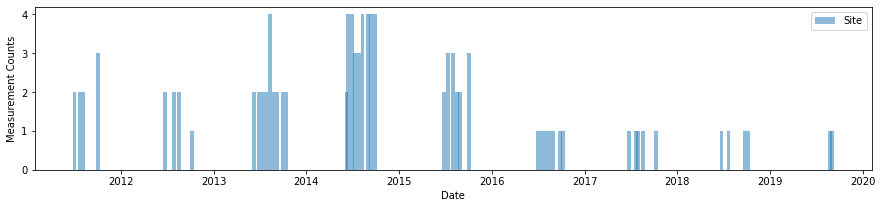

In [26]:
resampled_counts(oh_join, 'Collect Date', resample='W', cols=['Site'])

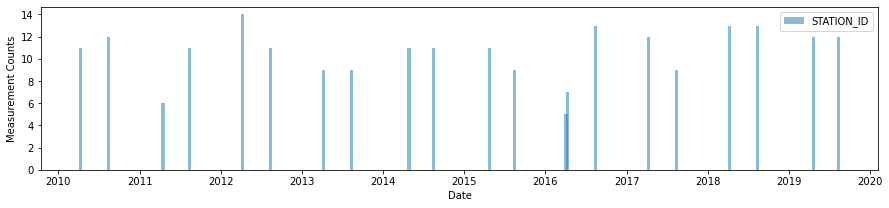

In [27]:
resampled_counts(glenda_join, 'SAMPLING_DATE', resample='W', cols=['STATION_ID'])

In [28]:
glenda_join['SAMPLING_DATE'].sort_values().unique()

array(['2010-04-07T17:04:00.000000000', '2010-04-07T17:11:00.000000000',
       '2010-04-07T18:11:00.000000000', '2010-04-07T18:25:00.000000000',
       '2010-08-09T14:15:00.000000000', '2010-08-09T14:22:00.000000000',
       '2010-08-09T15:32:00.000000000', '2010-08-09T15:33:00.000000000',
       '2011-04-11T20:05:00.000000000', '2011-04-11T20:06:00.000000000',
       '2011-08-09T19:40:00.000000000', '2011-08-09T19:42:00.000000000',
       '2011-08-09T22:26:00.000000000', '2011-08-09T22:33:00.000000000',
       '2012-04-07T19:07:00.000000000', '2012-04-07T20:29:00.000000000',
       '2012-04-07T21:29:00.000000000', '2012-08-09T18:46:00.000000000',
       '2012-08-09T18:55:00.000000000', '2012-08-09T20:02:00.000000000',
       '2013-04-01T19:52:00.000000000', '2013-04-01T21:16:00.000000000',
       '2013-08-09T20:13:00.000000000', '2013-08-09T21:32:00.000000000',
       '2014-04-23T15:59:00.000000000', '2014-04-23T16:13:00.000000000',
       '2014-04-23T17:12:00.000000000', '2014-04-23

In [29]:
oh_join['Collect Date'].sort_values().unique()

array(['2011-06-30T00:00:00.000000000', '2011-07-19T00:00:00.000000000',
       '2011-07-20T00:00:00.000000000', '2011-08-03T00:00:00.000000000',
       '2011-08-04T00:00:00.000000000', '2011-09-27T00:00:00.000000000',
       '2011-09-28T00:00:00.000000000', '2012-06-19T00:00:00.000000000',
       '2012-06-20T00:00:00.000000000', '2012-07-24T00:00:00.000000000',
       '2012-07-25T00:00:00.000000000', '2012-08-14T00:00:00.000000000',
       '2012-08-15T00:00:00.000000000', '2012-10-03T00:00:00.000000000',
       '2013-06-04T00:00:00.000000000', '2013-06-26T00:00:00.000000000',
       '2013-07-10T00:00:00.000000000', '2013-07-23T00:00:00.000000000',
       '2013-08-06T00:00:00.000000000', '2013-08-20T00:00:00.000000000',
       '2013-09-05T00:00:00.000000000', '2013-09-26T00:00:00.000000000',
       '2013-10-09T00:00:00.000000000', '2014-06-02T00:00:00.000000000',
       '2014-06-10T00:00:00.000000000', '2014-06-11T00:00:00.000000000',
       '2014-06-24T00:00:00.000000000', '2014-07-09

Just looking at the date distributions it seems there won't be much overlap. The GLENDA data is only measured in April and August, unfortunately. Let's rename the Ohio EPA columns to match the GLERL data and drop irrelevant columns.

In [30]:
oh_join.rename(columns={'Collect Date':'Date', 
                        'Lat':'Latitude (decimal deg)', 
                        'Long':'Longitude (decimal deg)', 
                        'Result':'Particulate Microcystin (µg/L)', 
                        'Collection Time':'Local Time (Eastern Time Zone)'}, inplace=True)

/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [31]:
oh_join.drop(columns=['Site ID', 'Site Type', 'Sample ID', 'Parameter', 'Units', 'Qual.*', 
                      'Program', 'Lab', 'Saturation'], inplace=True)

/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
oh_join.head()

,Site,Date,Local Time (Eastern Time Zone),Particulate Microcystin (µg/L),Latitude (decimal deg),Longitude (decimal deg)
13,Lake Erie North of Port Clinton,2018-10-02,10:05,0.00,41.55781,-82.93635
24,Lake Erie North of Port Clinton,2018-09-18,10:18,0.00,41.55781,-82.93635
67,Lake Erie North of Port Clinton,2018-07-18,10:40,0.00,41.55781,-82.93635
86,Lake Erie North of Port Clinton,2018-06-21,12:43,0.00,41.55781,-82.93635
139,Lake Erie North of Port Clinton,2017-10-02,12:08,1.65,41.55781,-82.93635


Now we can search through the Ohio EPA data and for each row locate measurements in the GLENDA dataframe that are spatiotemporally proximate (within 2 miles and 7 days), and join averages of any matching measurements to the Ohio data. Arguably it could be better to only select GLENDA data prior to the Ohio measurements, or on the exact date. However, let's be generous with a 14 day window to begin with just to see the overlap.

In [33]:
for i in oh_join.index:
    site = oh_join.loc[i, 'Site']
    lat = oh_join.loc[i, 'Latitude (decimal deg)']
    long = oh_join.loc[i, 'Longitude (decimal deg)']
    date = oh_join.loc[i, 'Date']
    tdelta = dt.timedelta(days=7)
    join = glenda_join[[coord in coords_dict[site] for coord in zip(glenda_join['LATITUDE'], 
                                                                    glenda_join['LONGITUDE'])]
                       & (abs(glenda_join['SAMPLING_DATE'] - date) < tdelta)]
    for col in ['Particulate Organic Carbon (mg/L)', 'Extracted Chlorophyll a (µg/L)', 
            'CTD Specific Conductivity (µS/cm)', 'Total Nitrogen (mg/L)', 
            'Nitrate + Nitrite (mg N/L)', 'CTD Dissolved Oxygen (mg/L)', 
            'Total Phosphorus (µg P/L)', 'Secchi Depth (m)', 'Total Suspended Solids (mg/L)', 
            'CTD Temperature (°C)', 'Turbidity (NTU)']:
        oh_join.loc[i, col] = join.mean()[col]

<ipython-input-33-61d0977b8555>:15: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  oh_join.loc[i, col] = join.mean()[col]
/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [34]:
oh_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 13 to 810
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Site                               101 non-null    object        
 1   Date                               101 non-null    datetime64[ns]
 2   Local Time (Eastern Time Zone)     101 non-null    object        
 3   Particulate Microcystin (µg/L)     101 non-null    float64       
 4   Latitude (decimal deg)             101 non-null    float64       
 5   Longitude (decimal deg)            101 non-null    float64       
 6   Particulate Organic Carbon (mg/L)  0 non-null      float64       
 7   Extracted Chlorophyll a (µg/L)     6 non-null      float64       
 8   CTD Specific Conductivity (µS/cm)  10 non-null     float64       
 9   Total Nitrogen (mg/L)              2 non-null      float64       
 10  Nitrate + Nitrite (mg N/L)         10

Disappointingly there is not much spatiotemporal overlap between the two data sets. There are only a handful of matches for restrictions within 2 miles and 7 days. In conclusion we will restrict our analysis to the GLERL dataset.